In [1]:
import cmdstanpy as stan
from scipy.special import logit, expit
from numpy.random import normal, choice, binomial, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ckmr_model = stan.CmdStanModel(stan_file='~/src/ckmr/src/sib.stan')
ckmr_model_full = stan.CmdStanModel(stan_file='~/src/ckmr/src/sib_full.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/alex/src/ckmr/src/sib
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/alex/src/ckmr/src/sib_full


In [3]:
df = pd.read_excel('PIRU_mykiss_parentage.xlsx')
df = df[df['Count'] > 0]
df = df[['Count']]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [26]:
def sub_sample(df, p=0.1):
    tot = df['Count'].sum()
    new_count = binomial(df['Count'], p)
    df1 = df[set(df.columns).difference({'Count'})]
    df1['Count'] = new_count
    df1 = df1[df1['Count'] > 0]
    return df1
    

def make_stan_data(df, method='normal', osr=[0.0, 0.01], prom=[-2.5, 0.11]):
    if method == 'normal':
        method = 1
    elif method == 'beta':
        method = 2
    else:
        raise ValueError(f'Invalid method: {method}')
    data = {
        'method': method,
        'osr_mu': osr[0],
        'osr_sigma': osr[1],
        'prom_mu': prom[0],
        'prom_sigma': prom[1],
        'F': len(df['Count']),
        'N': df['Count'].sum(),
        'size': df['Count'].values
    }
    return data

def plot_results(dfs, field='F0', ci=0.99, title=''):
    dfs = summarize_samples(dfs, ci=ci, field=field)
    ns = [d[0] for d in dfs]
    summaries = [d[1] for d in dfs]
    fig, ax = plt.subplots(figsize=(16, 9))
    y0 = [s[field].loc['mean'] for s in summaries]
    y1 = [s[field].iloc[4] for s in summaries]
    y2 = [s[field].iloc[6] for s in summaries]
    ax.plot(ns, y0, 'ko-', label='mean')
    ax.fill_between(ns, y1, y2, alpha=0.5, label=f'{(100*ci):.1f}% CI')
    ax.set_xlabel('sample size')
    ax.set_ylabel(f'{field} estimate')
    ax.set_title(title)
    ax.legend()
    
def sample_data(dfs, **kwargs):
    fits = [(d['Count'].sum(), ckmr_model_full.sample(data=make_stan_data(d), **kwargs)) for d in dfs]
    fits.sort(key=(lambda x: x[0]))
    return fits

def summarize_samples(fits, ci=0.99, field='F0'):
    lower = 0.5 * (1.0 - ci)
    upper = 1.0 - lower
    quants = (lower, upper)
    res = [(n, d.draws_pd([field]).describe(percentiles=quants)) for (n, d) in fits]
    return res
    
def make_synth_data(F0, N):
    fam = choice(F0, size=N, replace=True)
    one = np.repeat(1, N)
    df = pd.DataFrame(data={'family': fam, 'count': one})
    df = df.groupby(['family']).count()
    df.columns = [c.title() for c in df.columns]
    return df

In [5]:
dfs = (sub_sample(df, p=p) for p in np.arange(0.05, 1.0, 0.05))
fits = sample_data(dfs, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

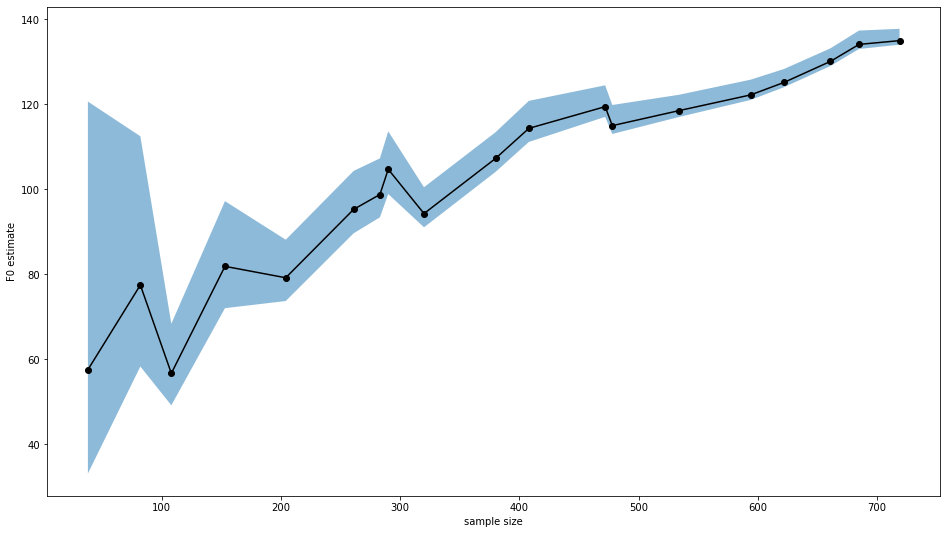

In [6]:
plot_results(fits, field='F0')

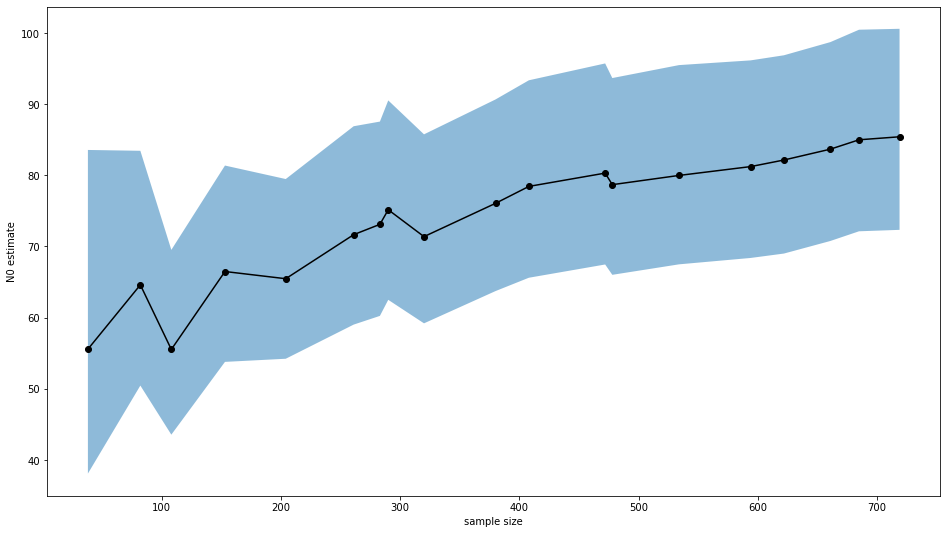

In [7]:
plot_results(fits, field='N0')

In [8]:
dfs1 = (make_synth_data(137, N) for N in range(100, 1000, 100))
fits1 = sample_data(dfs1, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

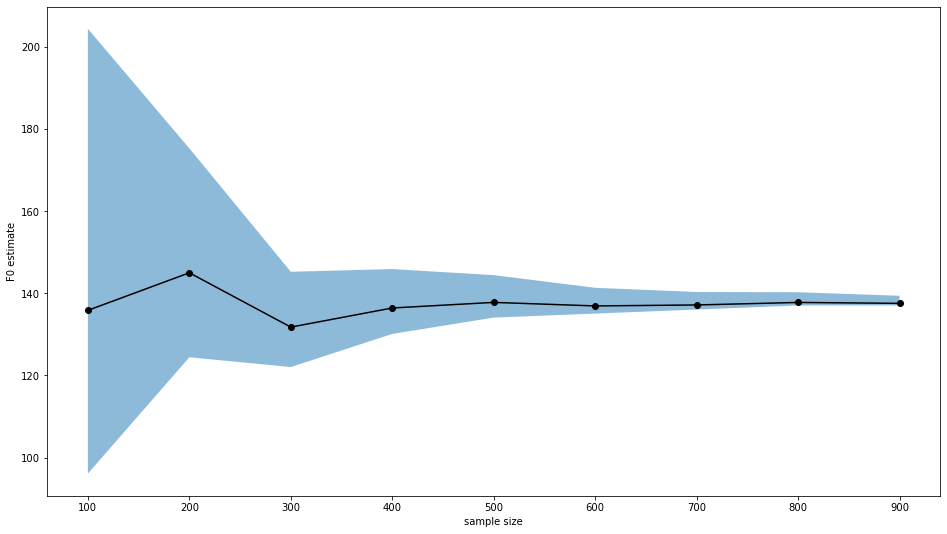

In [9]:
plot_results(fits1, field='F0')

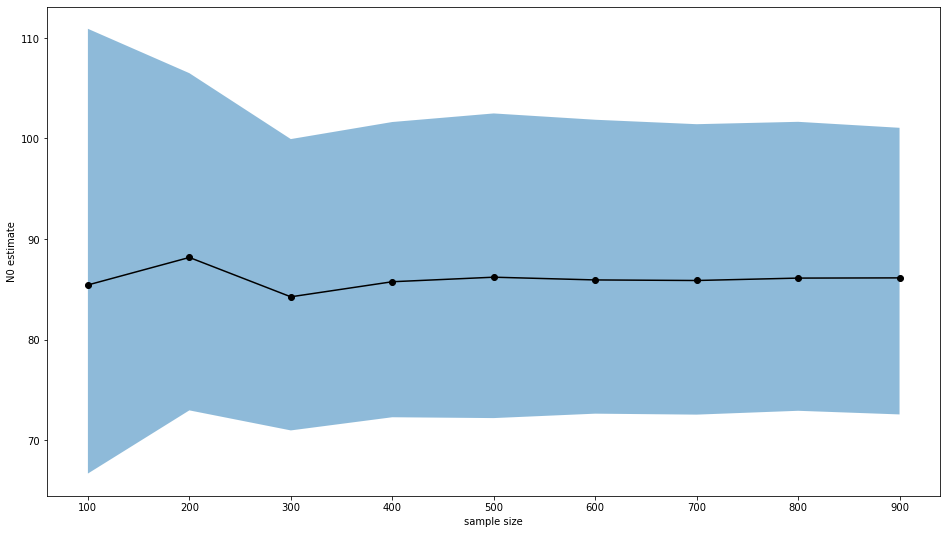

In [10]:
plot_results(fits1, field='N0')

In [4]:
dfs2 = (make_synth_data(1234, N) for N in range(200, 2200, 200))
fits2 = sample_data(dfs2, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

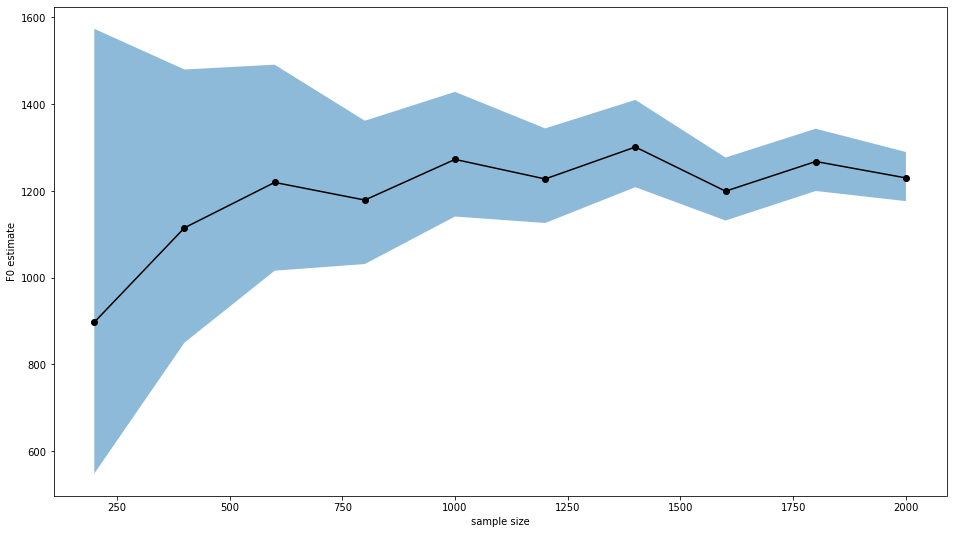

In [5]:
plot_results(fits2, field='F0')

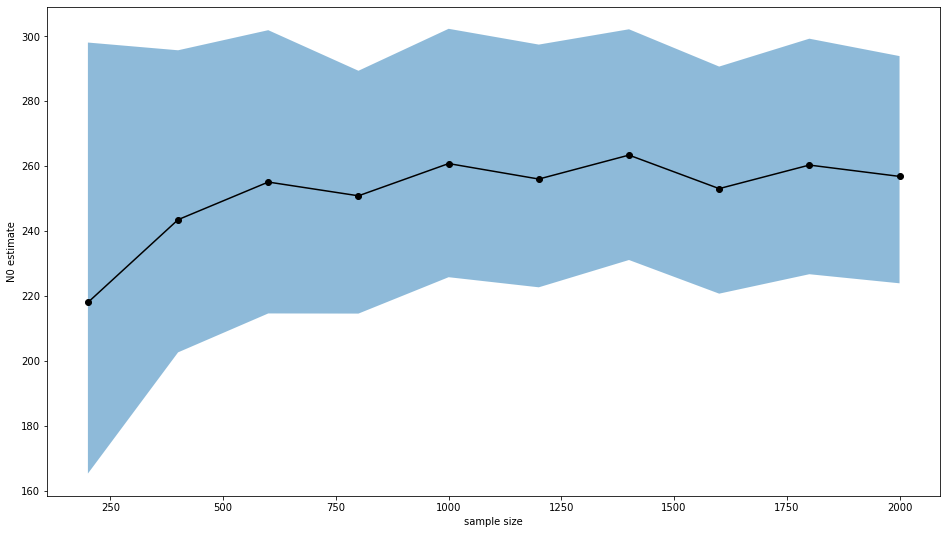

In [6]:
plot_results(fits2, field='N0')

In [4]:
df3 = pd.read_csv('/home/alex/src/ckmr/Stan_mykiss_2021_Run1.BestConfig')
df3 = df3.groupby('ClusterID').count()
df3 = df3[['OffspringID']].rename(columns={'OffspringID': 'Count'})
df3 = df3[df3['Count'] > 0]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [5]:
df3

,Count
ClusterID,
1,1
2,1
3,2
4,1
5,1
...,...
126,2
127,1
128,1


In [17]:
dfs3 = (sub_sample(df3, p=p) for p in np.linspace(0.2, 1.0, 9))
fits3 = sample_data(dfs3, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

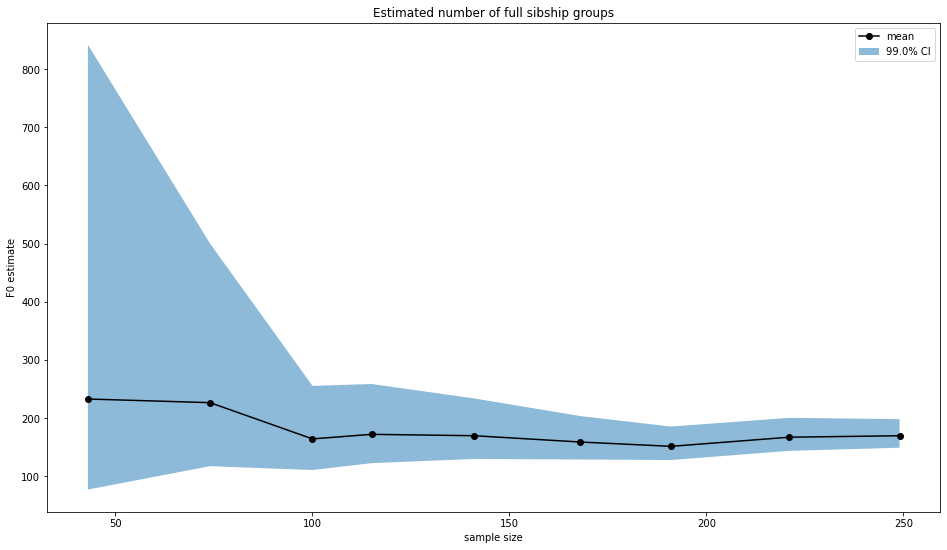

In [30]:
plot_results(fits3, field='F0', title='Estimated number of full sibship groups')

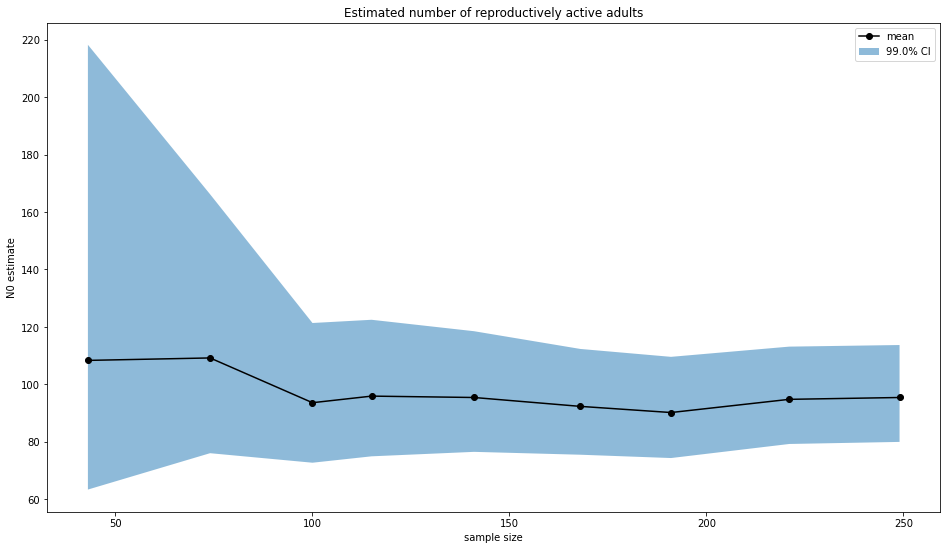

In [31]:
plot_results(fits3, field='N0', title='Estimated number of reproductively active adults')

In [29]:
fits3[-1][1].draws_pd(['F0', 'N0']).describe(percentiles=[0.005, 0.995])

,N0,F0
count,8000.000000,8000.000000
mean,95.409998,169.347164
std,6.520660,9.470917
min,73.739700,141.604000
0.5%,79.939799,148.744970
50%,95.174700,168.555500
99.5%,113.687445,197.977670
max,123.388000,216.985000


In [21]:
np.linspace(0.2, 1.0, 9)

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])